
## <font color='blue'>Projeto </font>
## <font color='blue'>Market Basket Analysis</font>

# O Que é MBA (Market Basket Analysis)?

A Análise de Cesta de Compras (Market Basket Analysis) é uma das principais técnicas usadas por grandes varejistas para descobrir associações entre itens. A técnica funciona procurando combinações de itens que ocorrem juntos com frequência nas transações. Em outras palavras, permite que os varejistas identifiquem as relações entre os itens que as pessoas compram.

A Análise de Cesta de Compras emprega algoritmos de regras de associação, que são amplamente utilizadas para analisar cesta de varejo ou dados de transação e têm o objetivo de identificar regras fortes descobertas em dados de transações comerciais usando medidas de interesse, com base no conceito de regras fortes.

## Instalando e Carregando os Pacotes

In [7]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.12.7


In [11]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations
import efficient_apriori
from efficient_apriori import apriori

In [1]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Guilherme Goldoni" --iversions

Author: Guilherme Goldoni

sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
numpy     : 1.26.4
pandas    : 2.2.3
json      : 2.0.9
ipywidgets: 7.8.1
xarray    : 2023.6.0
IPython   : 8.29.0



## Carregando os Dados

In [13]:
# Carrega os dados
aisle = pd.read_csv('dados/aisles.csv')
department = pd.read_csv('dados/departments.csv')
order = pd.read_csv('dados/orders.csv')
product = pd.read_csv('dados/products.csv')
order_product_prior = pd.read_csv('dados/order_products__prior.csv')
order_product_train = pd.read_csv('dados/order_products__train.csv')

## Análise Exploratória

Faz sentido calcular a correlação com colunas do tipo ID?

In [14]:
aisle.shape

(134, 2)

In [15]:
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [16]:
department.shape

(21, 2)

In [17]:
department.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [18]:
product.shape

(49688, 4)

In [19]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [20]:
order.shape

(3421083, 7)

In [21]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [22]:
order_product_prior.shape

(32434489, 4)

In [23]:
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [24]:
order_product_train.shape

(1384617, 4)

In [25]:
order_product_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


Por que não usar programação e verificar o total de registros em todos os datasets de uma vez?

In [26]:
# Total de registros por dataset
count_array = np.array([['Aisles', len(aisle)],
                        ['Department', len(department)],
                        ['Product', len(product)],
                        ['Order', len(order)],
                        ['Order_Product_Prior', len(order_product_prior)],
                        ['Order_Product_Train', len(order_product_train)]])
count_record = pd.DataFrame(count_array, columns = ['Arquivo', 'Total de Registros'])
count_record

,Arquivo,Total de Registros
0,Aisles,134
1,Department,21
2,Product,49688
3,Order,3421083
4,Order_Product_Prior,32434489
5,Order_Product_Train,1384617


In [27]:
# Total de itens nas categorias de eval_set
order['eval_set'].value_counts()

eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64

## Limpeza dos Dados

### Verificando Valores Ausentes

In [28]:
aisle.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [29]:
department.isna().sum()

department_id    0
department       0
dtype: int64

In [30]:
order.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [31]:
product.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [32]:
order_product_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [33]:
order_product_train.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

### Feature Extraction

### Merge da Tabela order_product_prior com order, product, aisle e department

In [34]:
# Merge
order_product_prior = order_product_prior.merge(order, on = 'order_id', how = 'left')
order_product_prior = order_product_prior.merge(product, on = 'product_id', how = 'left')
order_product_prior = order_product_prior.merge(aisle, on = 'aisle_id', how = 'left')
order_product_prior = order_product_prior.merge(department, on = 'department_id', how = 'left')

In [35]:
order_product_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry
5,2,17794,6,1,202279,prior,3,5,9,8.0,Carrots,83,4,fresh vegetables,produce
6,2,40141,7,1,202279,prior,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13,doughs gelatins bake mixes,pantry
7,2,1819,8,1,202279,prior,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry
8,2,43668,9,0,202279,prior,3,5,9,8.0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce
9,3,33754,1,1,205970,prior,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs


In [36]:
order_product_prior.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [37]:
order_product_prior.isnull().sum() / len(order_product_prior) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

Vamos manter a variável days_since_prior_order por duas razões:

1- O percentual de valores ausentes é apenas de 6.4%.

2- Não usaremos a variável com o algoritmo MBA.

### Merge da Tabela order_product_train com order, product, aisle e department

In [38]:
%%time
order_product_train = order_product_train.merge(order, on = 'order_id', how = 'left')
order_product_train = order_product_train.merge(product, on = 'product_id', how = 'left')
order_product_train = order_product_train.merge(aisle, on = 'aisle_id', how = 'left')
order_product_train = order_product_train.merge(department, on = 'department_id', how = 'left')

CPU times: total: 2.81 s
Wall time: 3.13 s


In [39]:
order_product_train.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
5,1,13176,6,0,112108,train,4,4,10,9.0,Bag of Organic Bananas,24,4,fresh fruits,produce
6,1,47209,7,0,112108,train,4,4,10,9.0,Organic Hass Avocado,24,4,fresh fruits,produce
7,1,22035,8,1,112108,train,4,4,10,9.0,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs
8,36,39612,1,0,79431,train,23,6,18,30.0,Grated Pecorino Romano Cheese,2,16,specialty cheeses,dairy eggs
9,36,19660,2,1,79431,train,23,6,18,30.0,Spring Water,115,7,water seltzer sparkling water,beverages


In [40]:
order_product_train.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

> Vamos agrupar os dados para aplicar o algoritmo Apriori e preparar o dataset com todas as transações.

In [41]:
%%time
order_grouped = pd.DataFrame(order_product_prior.groupby('order_id')['product_id'])

CPU times: total: 4min 32s
Wall time: 4min 48s


In [42]:
order_grouped.shape

(3214874, 2)

In [43]:
len(order_grouped[0])

3214874

In [44]:
order_grouped.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


In [45]:
# Listas
prod = []

In [46]:
%%time
for i in range(len(order_grouped[0])):
    prod.append(list(order_grouped.iloc[i][1]))

CPU times: total: 3min 34s
Wall time: 3min 44s


In [47]:
prod_ = prod

In [48]:
order_ = order_grouped[0]

In [49]:
# Prepara o dataframe
transactions = pd.DataFrame({'OrderID' : order_, 'Products' : prod_})

In [50]:
transactions.head(10)

,OrderID,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


## Análise Estatística Descritiva

### 1- Qual o Número de Pedidos Mais Frequente Entre os Usuários?

In [51]:
# Agrupa os dados por usuário e número do pedido, agregando pelo maior valor
ord_max_count = order.groupby("user_id")['order_number'].max().reset_index()
ord_max_count.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [52]:
# Faz a contagem por número de pedidos
ord_max_count = ord_max_count['order_number'].value_counts()
ord_max_count.head()

order_number
4    23986
5    19590
6    16165
7    13850
8    11700
Name: count, dtype: int64

In [53]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


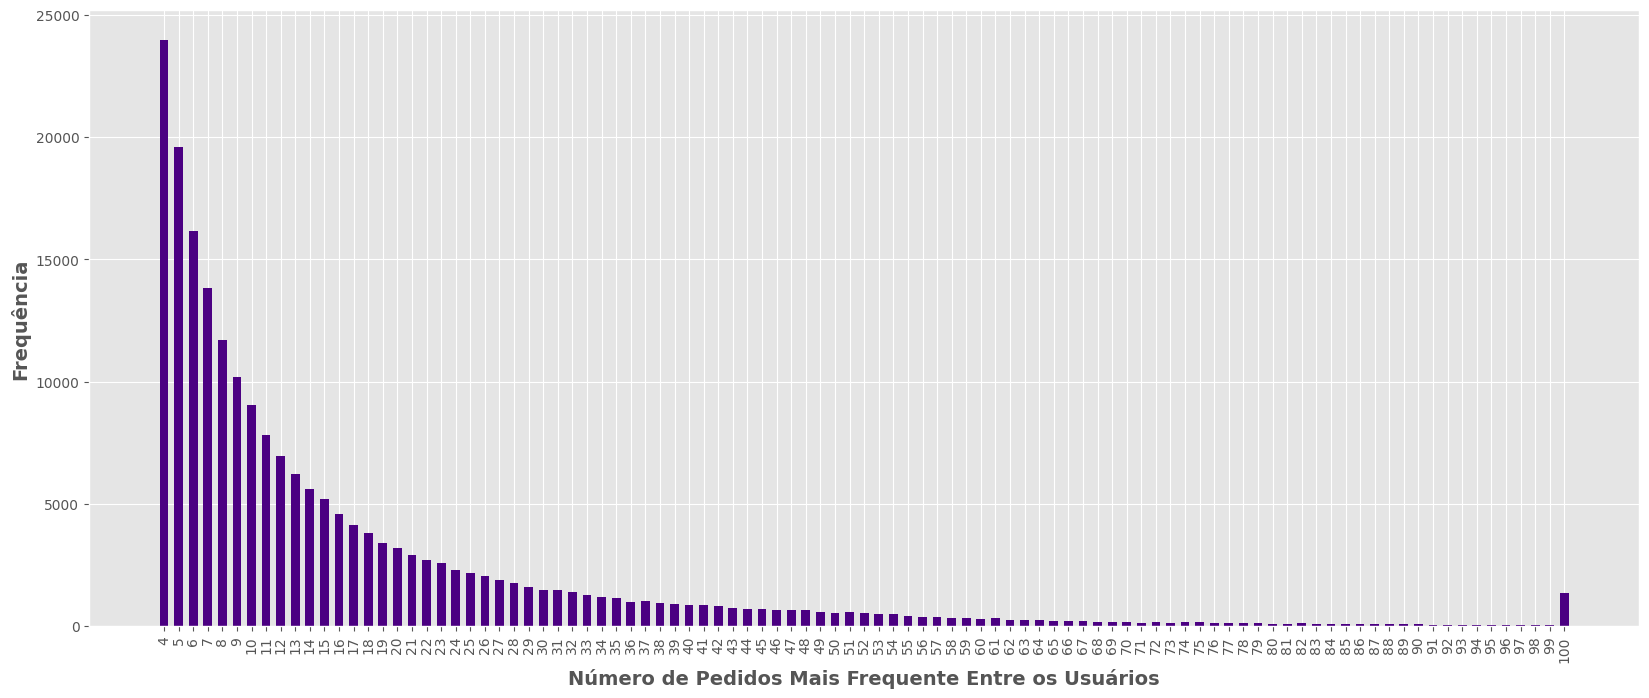

In [54]:
# Plot
plt.style.use('ggplot')
plt.figure(figsize = (20,8))
plt.bar(ord_max_count.index, ord_max_count.values, color = 'indigo', width = 0.6)
plt.xticks(ord_max_count.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de Pedidos Mais Frequente Entre os Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

### 2- Qual Dia da Semana Tem o Maior Número de Pedidos?

In [55]:
# Frequências de pedidos por dia da semana (dow = day of the week)
x = [0,1,2,3,4,5,6]
y = [order[order['order_dow']==0].shape[0],
     order[order['order_dow']==1].shape[0],
     order[order['order_dow']==2].shape[0],
     order[order['order_dow']==3].shape[0],
     order[order['order_dow']==4].shape[0],
     order[order['order_dow']==5].shape[0],
     order[order['order_dow']==6].shape[0]]

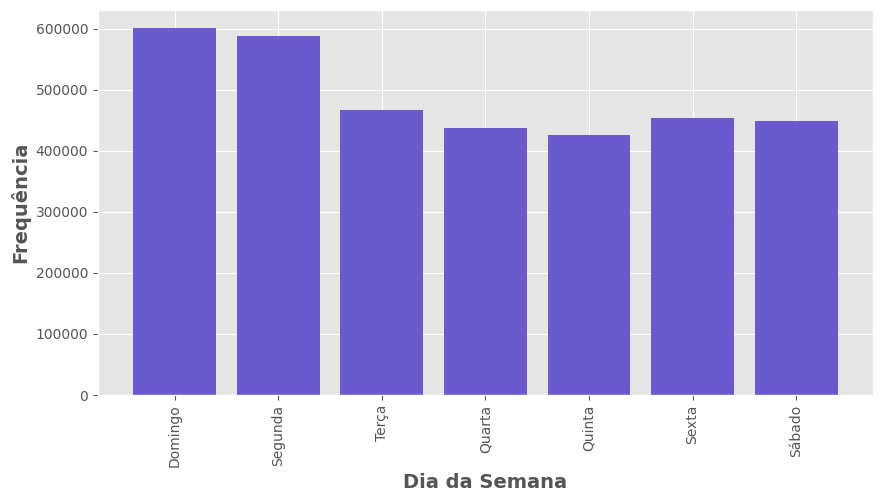

In [56]:
# Plot
plt.figure(figsize = (10,5))
plt.bar(x,y, color = 'slateblue')
plt.xlabel('Dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(x,['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 'vertical')
plt.show()

### 3- Qual Hora do Dia Tem o Maior Número de Pedidos?

In [57]:
# Frequências de pedidos pela hora do dia
x = list(range(0,24))
y = []
for i in range(24):
    y.append(order[order['order_hour_of_day']==i].shape[0])

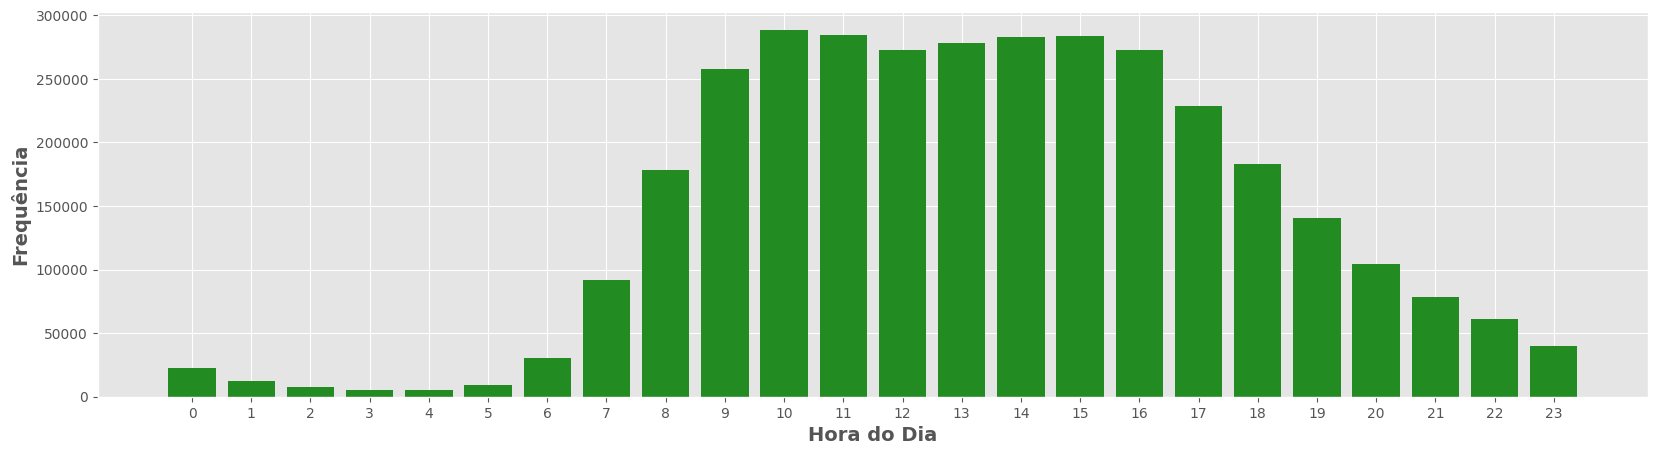

In [58]:
# Plot
plt.figure(figsize = (20,5))
plt.bar(x,y,color = 'forestgreen')
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 4- Qual Departamento Tem o Maior Número de Pedidos?

In [59]:
# Contagem de pedidos por departamento
dept_cnt = order_product_prior['department'].value_counts()

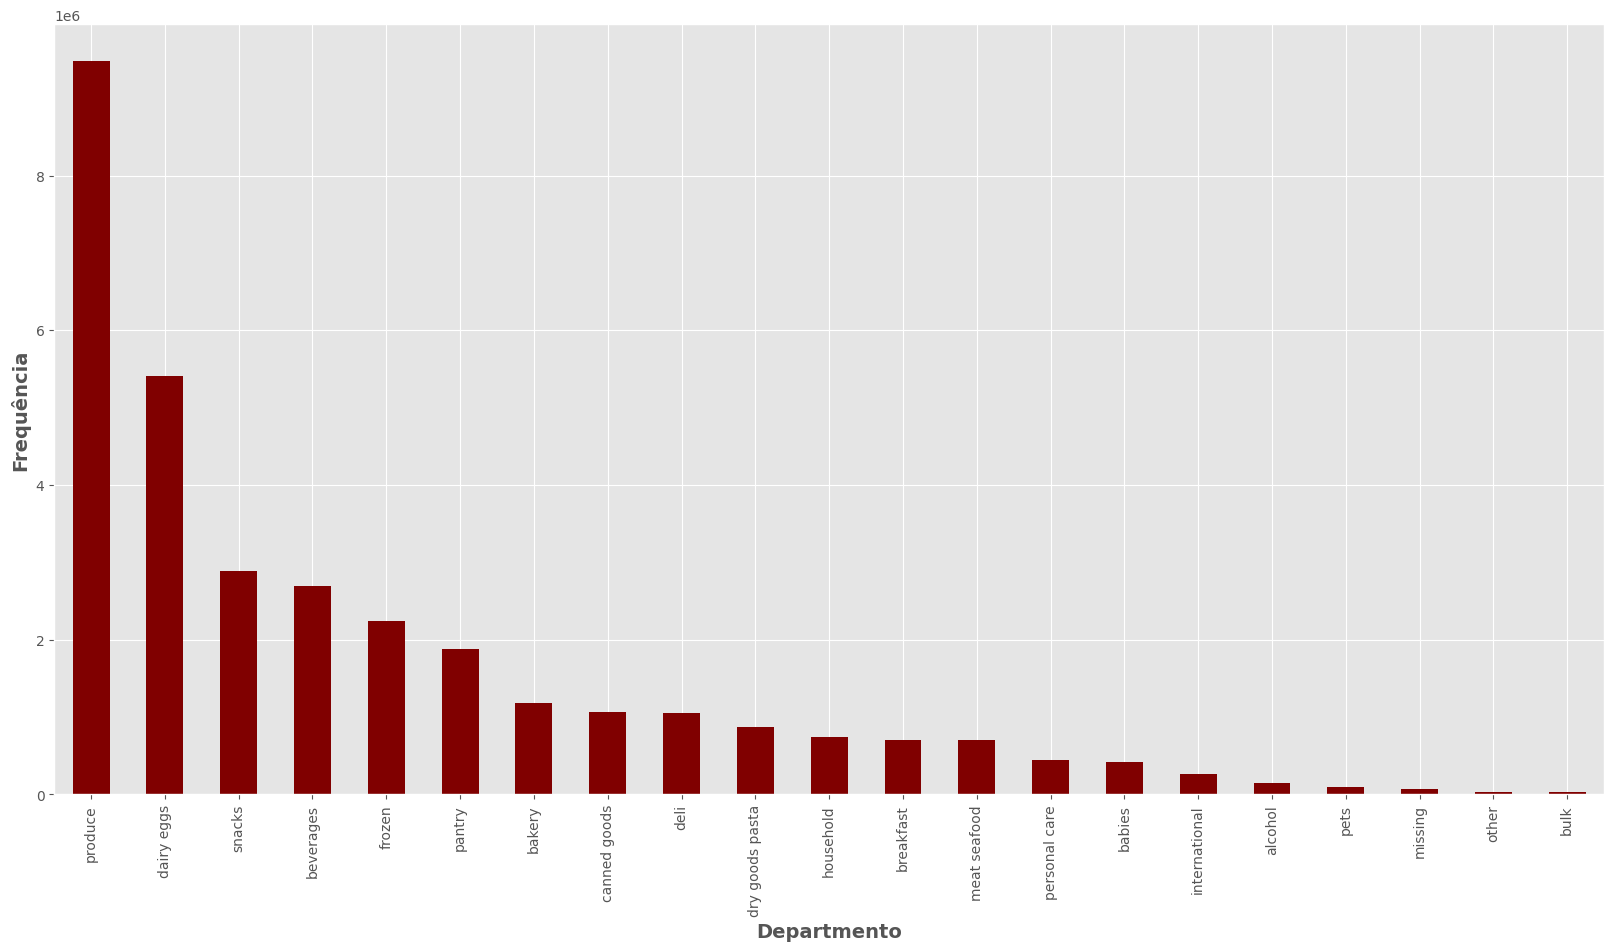

In [60]:
# Plot
fig = plt.figure(figsize = (20,10))
dept_cnt.plot(kind = "bar", color = 'maroon')
plt.xticks(rotation = 90)
plt.xlabel('Departmento', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 5- Quais os 20 Principais Corredores Por Frequência de Pedidos?

In [61]:
# Os 20 principais corredores e sua frequência de pedidos
aisle_cnt = order_product_prior['aisle'].value_counts()

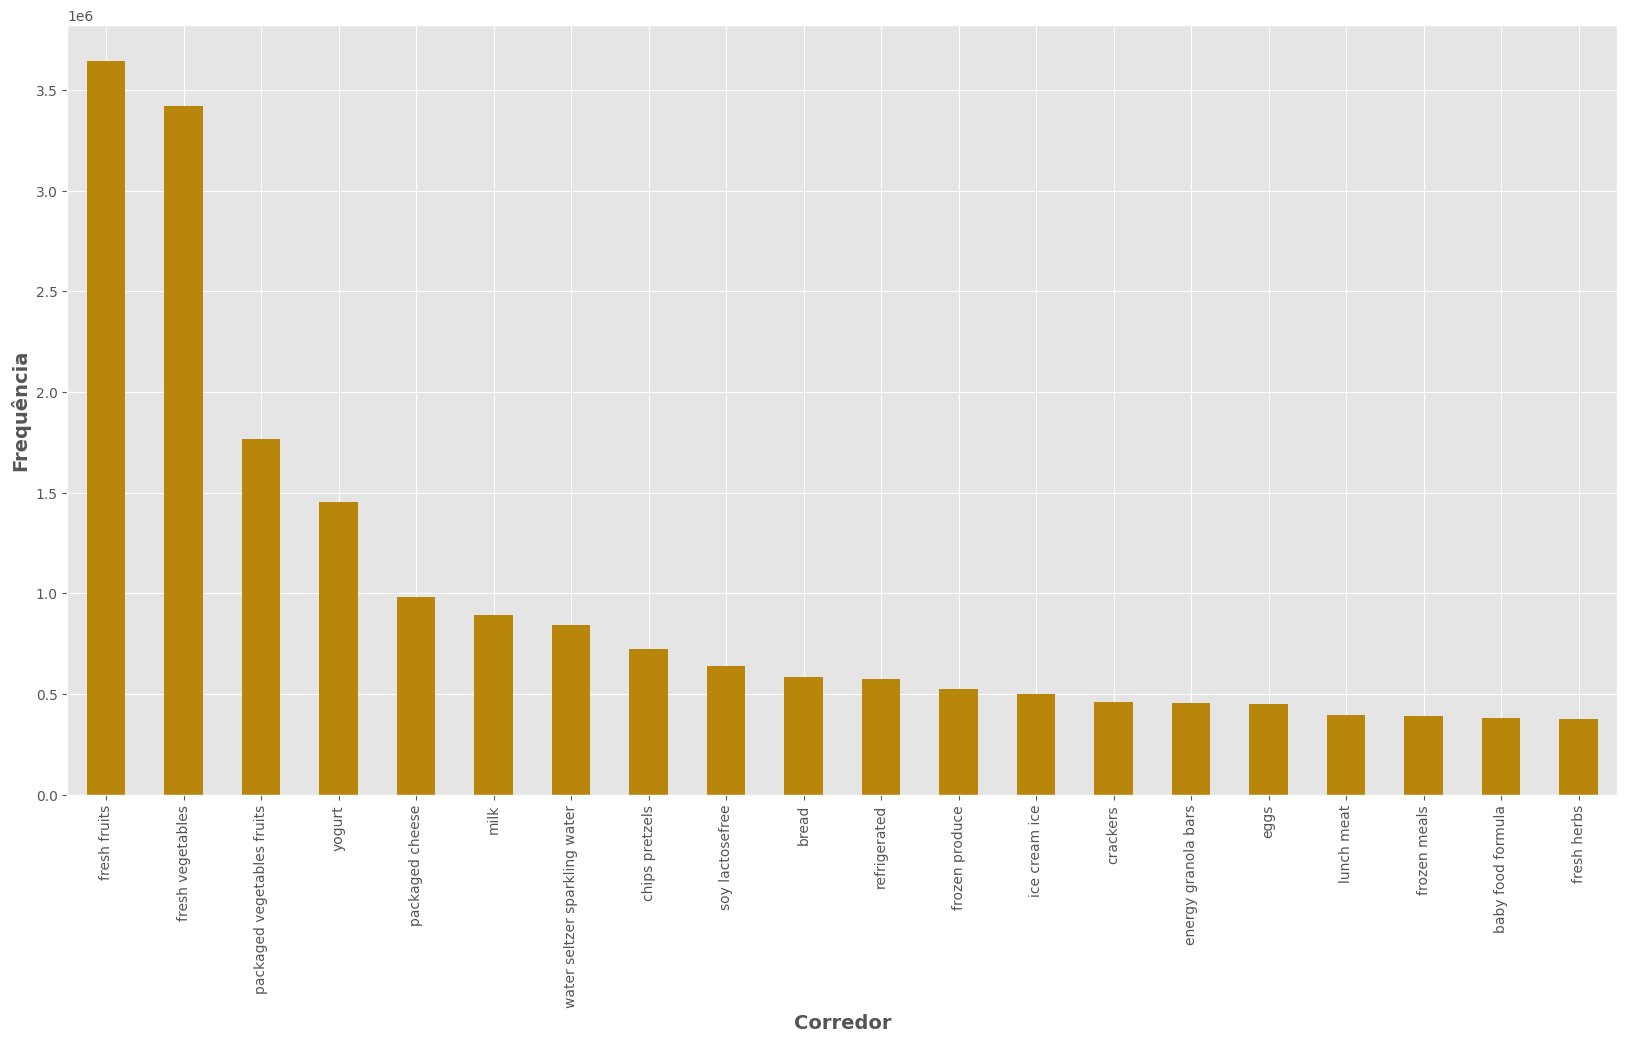

In [62]:
# Plot
fig = plt.figure(figsize = (20,10))
aisle_cnt[0:20].plot(kind = "bar", color = 'darkgoldenrod')
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 6- Quais os 20 Principais Produtos Por Frequência de Pedidos?

In [63]:
# Os 20 principais produtos por frequência de pedido
prod_cnt = order_product_prior['product_name'].value_counts()

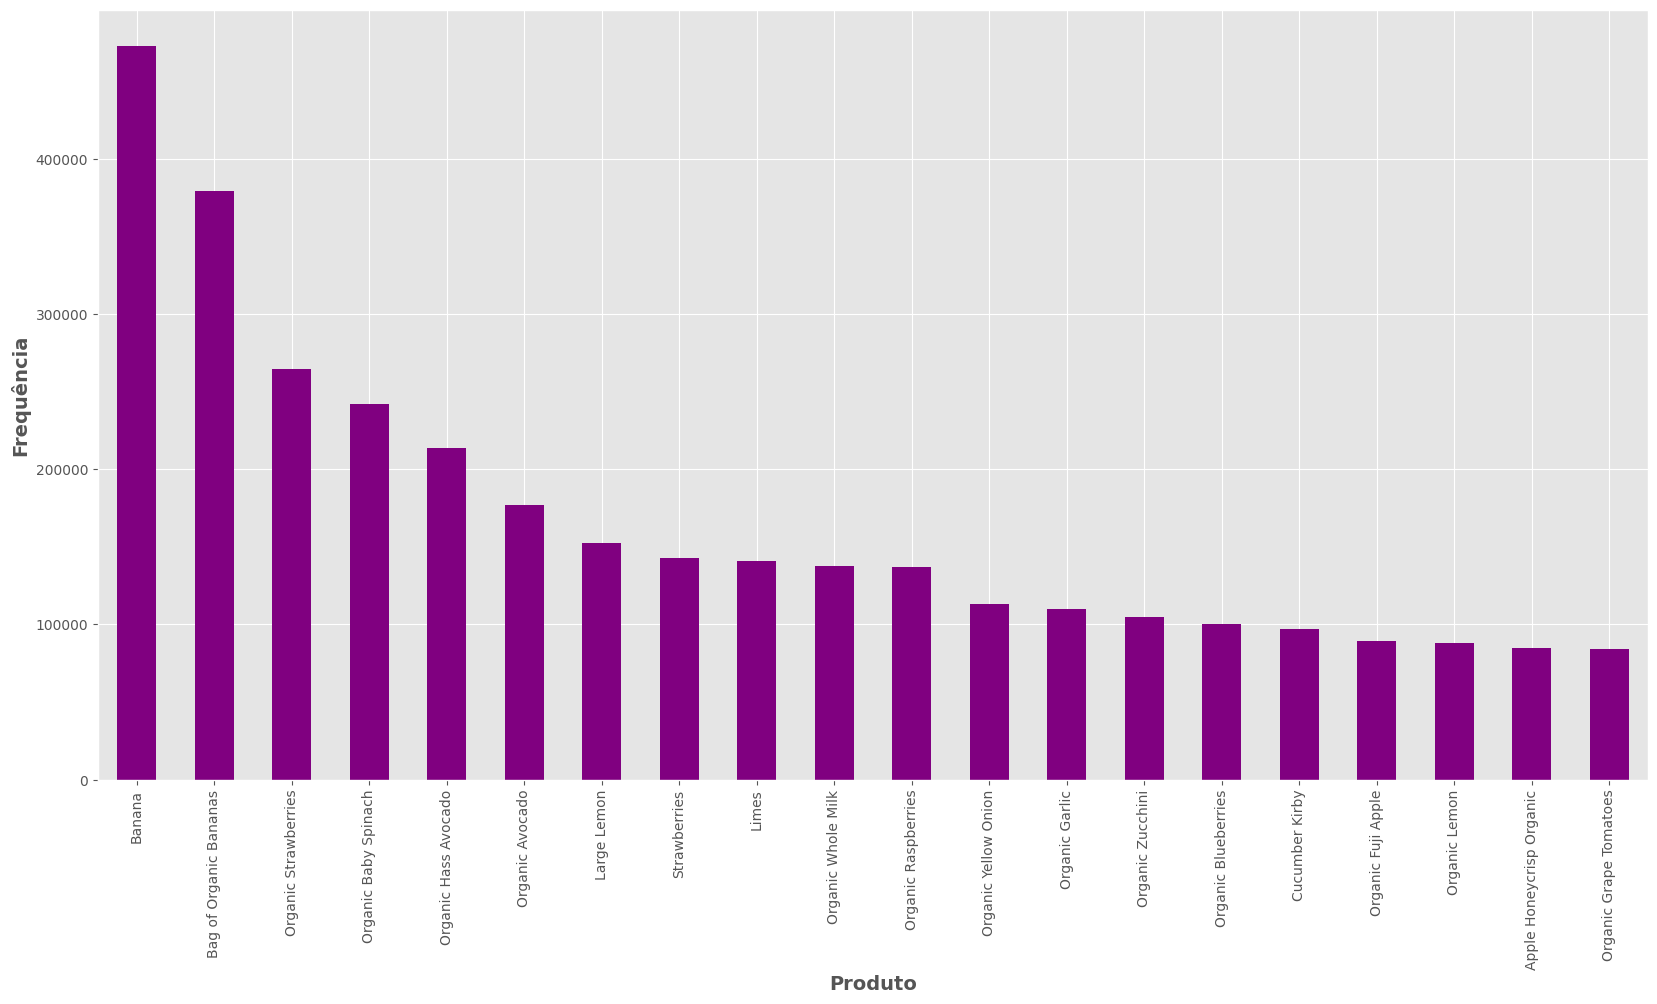

In [64]:
# Plot
fig = plt.figure(figsize = (20,10))
prod_cnt[0:20].plot(kind = "bar", color = 'purple')
plt.xticks(rotation = 90)
plt.xlabel('Produto', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

### 7- Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (reorder)

In [65]:
%%time
temp_df = order_product_prior.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()


CPU times: total: 10.3 s
Wall time: 10.9 s


In [66]:
# Prepara as listas
labels = list(temp_df.product_name[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])    

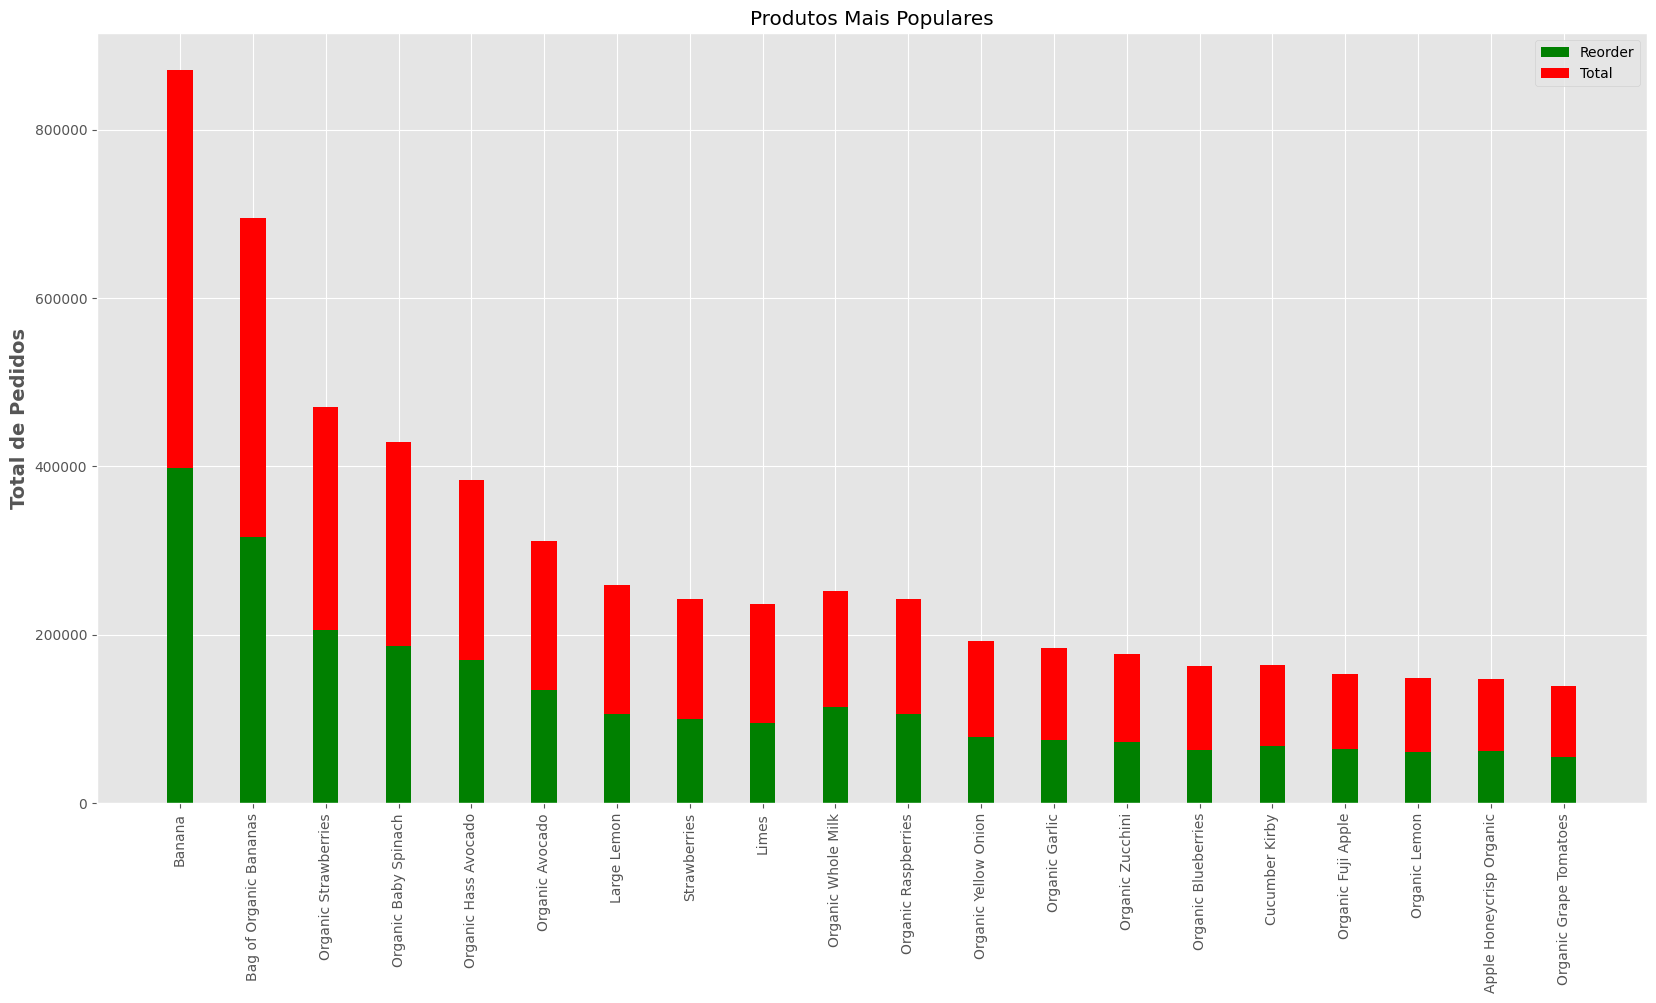

In [67]:
# Plot  
width = 0.35 
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Produtos Mais Populares")
plt.xticks(rotation = 90)
plt.show()

### 7- Análise de Reorder Por Departamento ao Longo do Tempo

In [68]:
# Agrupando os dados por departamento e reorder
grouped_df = order_product_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


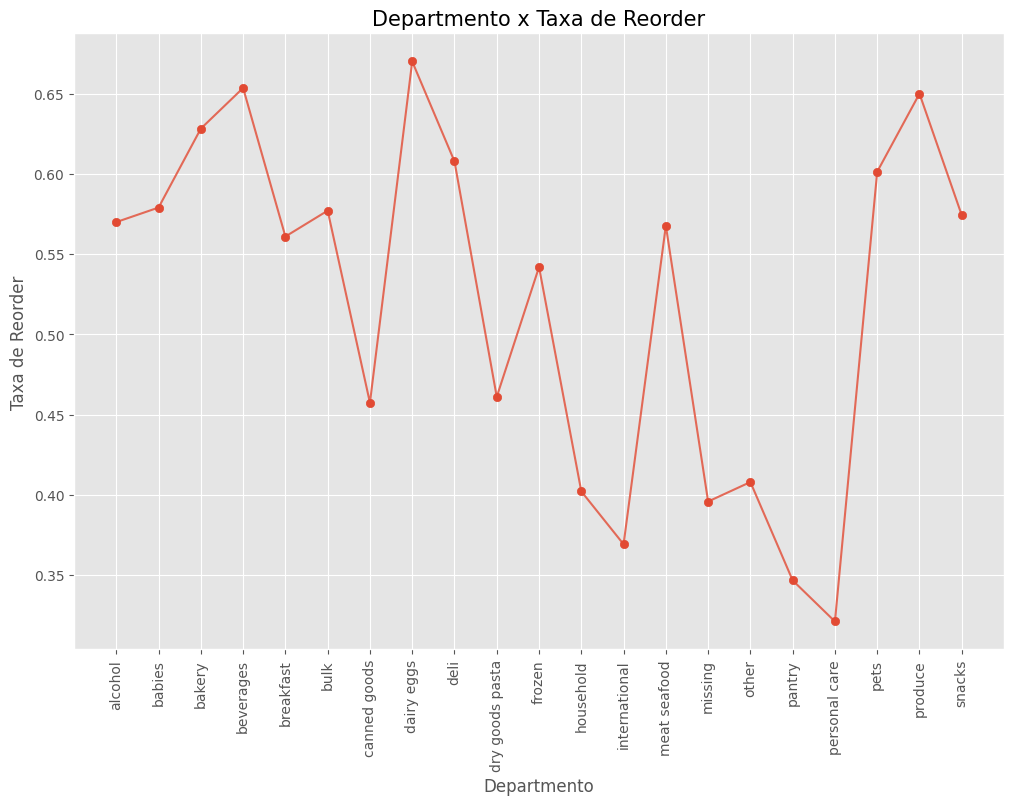

In [69]:
# Plot
plt.figure(figsize = (12,8))
plt.plot(list(grouped_df['department']), grouped_df['reordered'].values, alpha=0.8)
plt.scatter(list(grouped_df['department']), grouped_df['reordered'].values)
plt.ylabel('Taxa de Reorder', fontsize = 12)
plt.xlabel('Departmento', fontsize = 12)
plt.title("Departmento x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

### 8- Análise de Reorder e Pedidos

In [70]:
%%time
temp_df = order_product_prior.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()


CPU times: total: 4.06 s
Wall time: 4.39 s


In [71]:
temp_df.head()

,department,total,reorders
0,produce,9479291,6160710
1,dairy eggs,5414016,3627221
2,snacks,2887550,1657973
3,beverages,2690129,1757892
4,frozen,2236432,1211890


In [72]:
# Listas
labels = list(temp_df.department[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

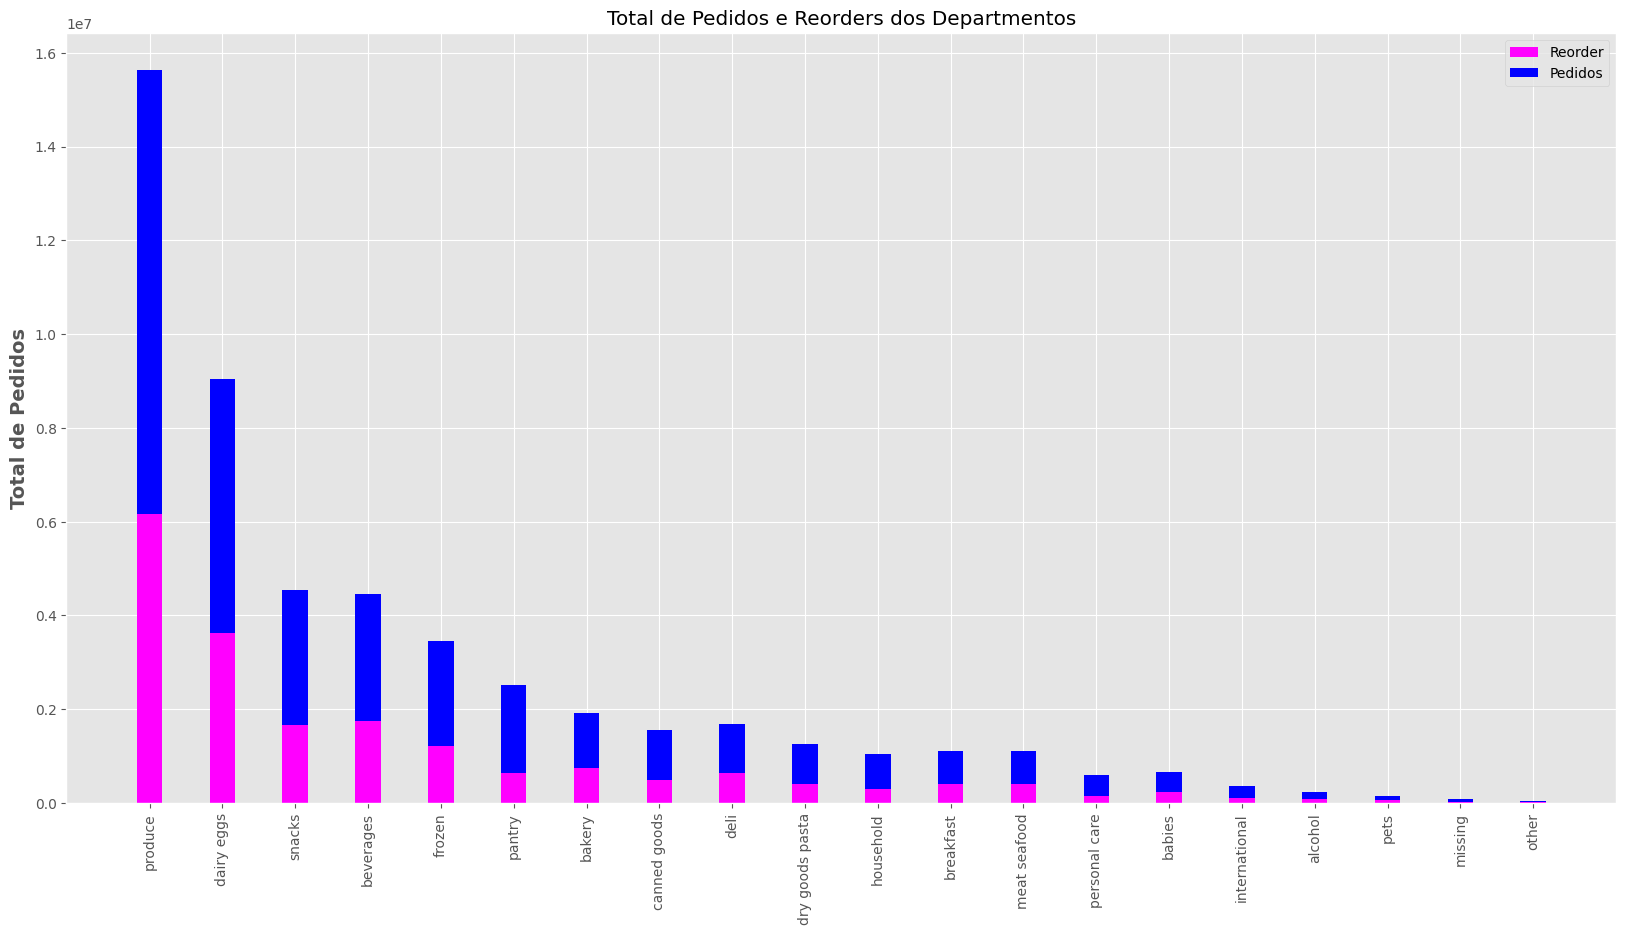

In [73]:
# Plot
width = 0.35  
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'magenta')
ax.bar(labels, total, width, bottom = reorder, label = 'Pedidos', color = 'blue')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Departmentos")
plt.xticks(rotation = 90)
plt.show()

### 9- Análise de Reorder Por Corredor

In [74]:
grouped_df = order_product_prior.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,aisle,reordered
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259


In [75]:
list(grouped_df['aisle'])[0:20]

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce']

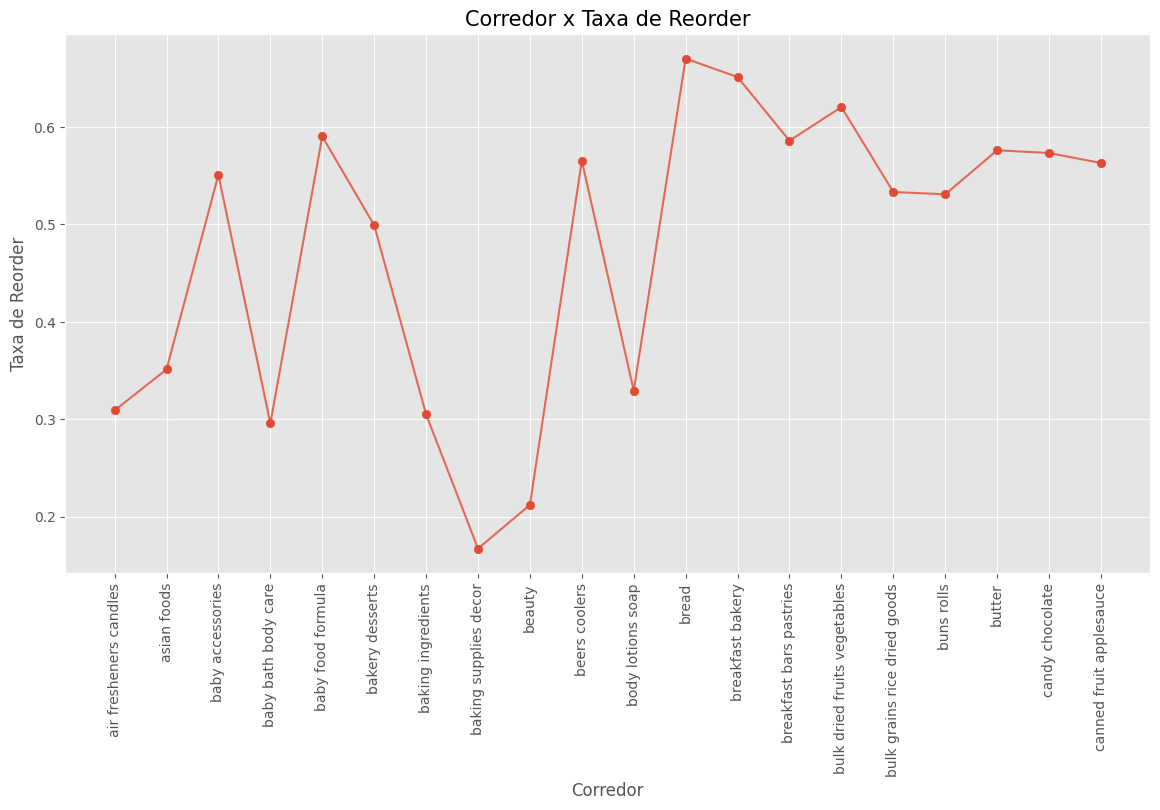

In [76]:
# Corredor x Taxa de Reorder
plt.figure(figsize=(14,7))
plt.plot(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20], alpha=0.8)
plt.scatter(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20])
plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Corredor', fontsize=12)
plt.title("Corredor x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

### 10- Análise de Reorder Por Corredor (Total)

In [77]:
%%time
temp_df = order_product_prior.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()


CPU times: total: 4.7 s
Wall time: 4.9 s


In [78]:
temp_df.head()

,aisle,total,reorders
0,fresh fruits,3642188,2615469
1,fresh vegetables,3418021,2032172
2,packaged vegetables fruits,1765313,1127177
3,yogurt,1452343,997018
4,packaged cheese,979763,573383


In [79]:
# Listas
labels = list(temp_df.aisle[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

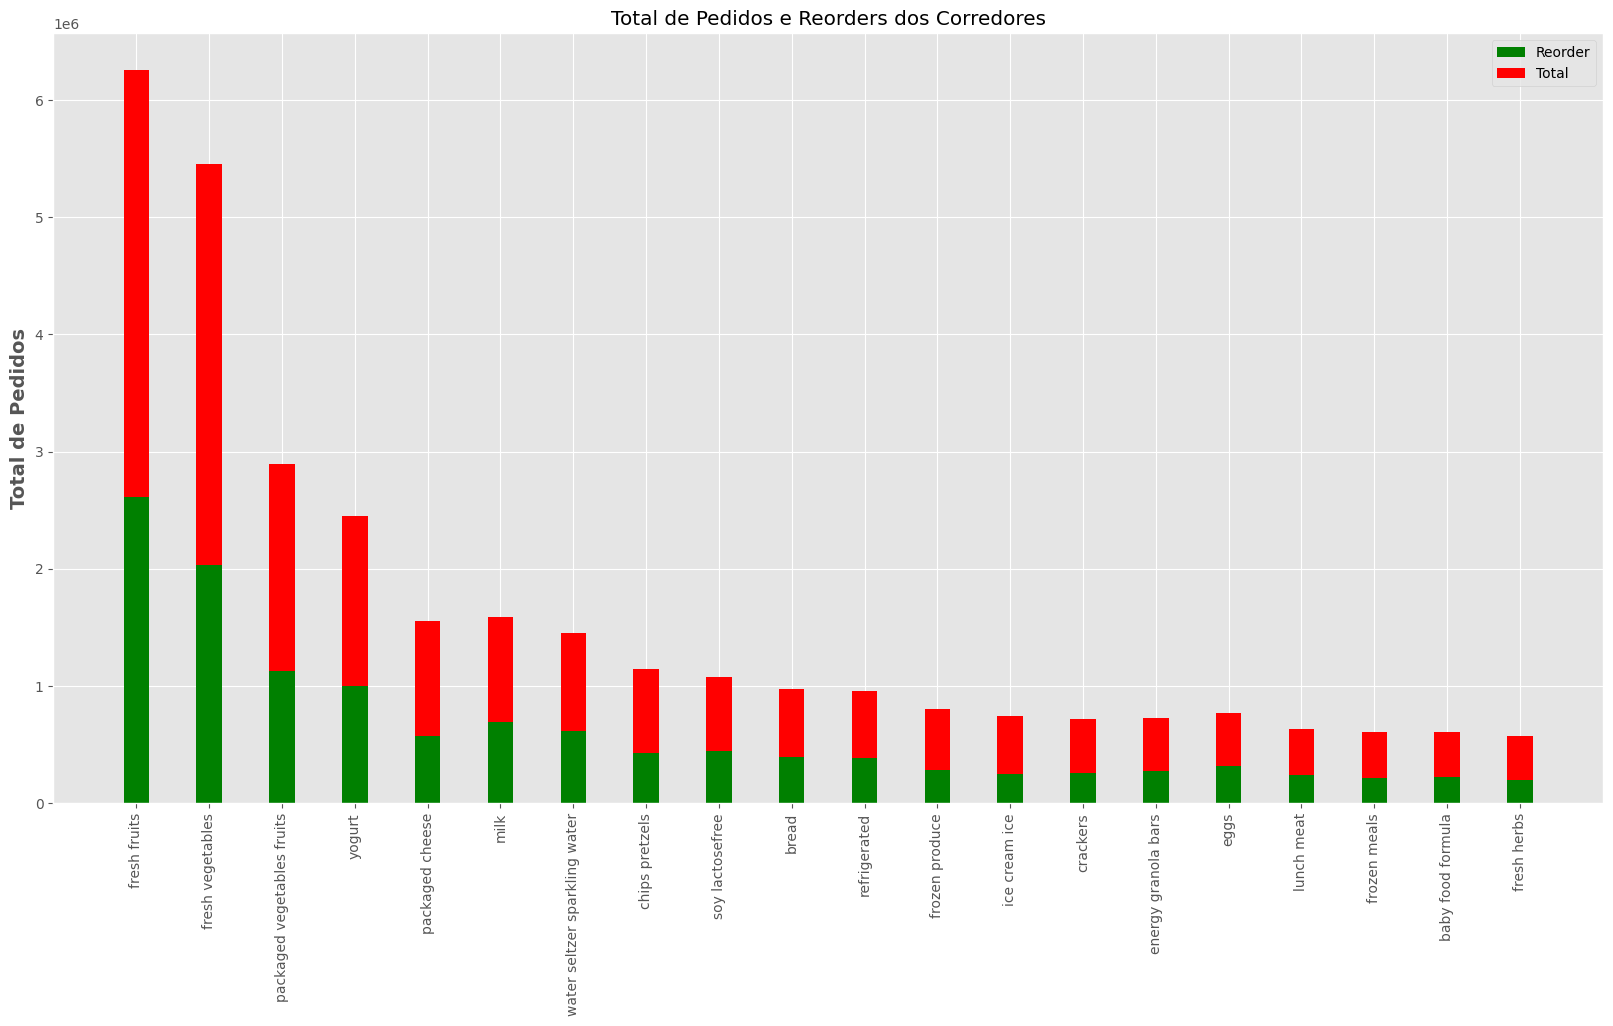

In [80]:
# Plot
width = 0.35      
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Corredores")
plt.xticks(rotation = 90)
plt.show()

> Vamos verificar a relação entre como a ordem de adição do produto ao carrinho afeta a proporção de novos pedidos

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
!pip install -q shutup

In [83]:
import shutup; shutup.please()

In [84]:
order_product_prior["add_to_cart_order_mod"] = order_product_prior["add_to_cart_order"].copy()
order_product_prior["add_to_cart_order_mod"].loc[order_product_prior["add_to_cart_order_mod"] > 70] = 70
grouped_df = order_product_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

In [85]:
grouped_df.head(10)

,add_to_cart_order_mod,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383
5,6,0.600420
6,7,0.585687
7,8,0.573247
8,9,0.561474
9,10,0.551018


## Implementação do Algoritmo Apriori

In [86]:
# Prepara a tupla com as transações
transactions_tup = [tuple(row) for row in transactions['Products'].tolist()]

### Executa o Algoritmo Apriori Com Support = 0.01 e Confidence = 0.2

In [87]:
st = datetime.now()
itemsets_ap, rules_ap = apriori(transactions_tup[:500000], min_support = 0.01, min_confidence = 0.2)
print('Tempo de Execução : ', datetime.now() - st)

Tempo de Execução :  0:00:06.455924


In [88]:
rules_ap

[{21137} -> {13176},
 {21903} -> {13176},
 {27966} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {21903} -> {24852},
 {28204} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852}]

In [89]:
# Listas de itens para considerar
item_A = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item_B = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B

In [90]:
# Listas para as métricas
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

In [91]:
# Loop
for i in range(len(temp)):
    
    # Calcula o support de A
    support_A.append(itemsets_ap[1][tuple([temp['itemA'][i],])] / 500000)
    
    # Calcula o support de B
    support_B.append(itemsets_ap[1][tuple([temp['itemB'][i],])] / 500000)
    
    # Calcula o support de A e B
    if tuple([temp['itemA'][i],temp['itemB'][i]]) in itemsets_ap[2].keys():
        support_AB.append(itemsets_ap[2][tuple([temp['itemA'][i],temp['itemB'][i]])] / 500000)
    else:
        support_AB.append(itemsets_ap[2][tuple([temp['itemB'][i],temp['itemA'][i]])] / 500000)
    
    # Calcula a confidence
    confidence_AB.append(support_AB[i] / support_A[i])
    
    # Calcula o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [92]:
# Dataframe com as regras de associação
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['Support_A'] = support_A
df_rules_ap['Support_B'] = support_B
df_rules_ap['Support_AB'] = support_AB
df_rules_ap['Confidence_AB'] = confidence_AB
df_rules_ap['Lift_AB'] = lift_AB

In [93]:
df_rules_ap.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784


In [94]:
df_rules_ap.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356


### Executa o Algoritmo Apriori Com Support = 0.005 e Confidence = 0.2

In [95]:
st = datetime.now()
itemsets_ap_1, rules_ap_1 = apriori(transactions_tup[:500000], min_support = 0.005, min_confidence = 0.2)
print('Tempo de Execução: ', datetime.now() - st)

Tempo de Execução:  0:00:12.965233


In [96]:
rules_ap_1

[{4605} -> {24852},
 {4920} -> {24852},
 {5876} -> {13176},
 {5876} -> {47209},
 {8277} -> {13176},
 {8277} -> {24852},
 {9076} -> {24852},
 {19057} -> {13176},
 {21137} -> {13176},
 {21903} -> {13176},
 {22935} -> {13176},
 {27966} -> {13176},
 {30391} -> {13176},
 {37646} -> {13176},
 {39275} -> {13176},
 {45007} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {30391} -> {21137},
 {39275} -> {21137},
 {21903} -> {24852},
 {24964} -> {22935},
 {26209} -> {24852},
 {27845} -> {24852},
 {28204} -> {24852},
 {30489} -> {24852},
 {37646} -> {24852},
 {40706} -> {24852},
 {42265} -> {24852},
 {44632} -> {24852},
 {45066} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852},
 {31717} -> {26209},
 {30391} -> {47209}]

In [97]:
# Lista de itens para considerar
item_A1 = [27966,47209,4605,21137,47766,21903,49683,5876,37646,40706,47626,5876,30391,22935,37646,31717,
           28204,27845,24964,45066,9076,16797,21903,8277,30391,21137,27966,19057,26209,45007,39275,30489,
           42265,30391,8277,4920,39275,44632]
item_B1 = [13176,13176,24852,24852,24852,24852,24852,47209,24852,24852,24852,13176,13176,13176,13176,26209,
           24852,24852,22935,24852,24852,24852,13176,24852,47209,13176,21137,13176,24852,13176,21137,24852,
           24852,21137,13176,24852,13176,24852]
temp1 = pd.DataFrame()
temp1['itemA'] = item_A1
temp1['itemB'] = item_B1

In [98]:
# Listas de métricas
support_A1 = []
support_B1 = []
support_AB1 = []
confidence_AB1 = []
lift_AB1 = []

In [99]:
# Loop
for i in range(len(temp1)):
    
    support_A1.append(itemsets_ap_1[1][tuple([temp1['itemA'][i],])] / 500000)
    
    support_B1.append(itemsets_ap_1[1][tuple([temp1['itemB'][i],])] / 500000)
    
    if tuple([temp1['itemA'][i],temp1['itemB'][i]]) in itemsets_ap_1[2].keys():
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemA'][i],temp1['itemB'][i]])] / 500000)
    else:
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemB'][i],temp1['itemA'][i]])] / 500000)
    
    confidence_AB1.append(support_AB1[i] / support_A1[i])
    
    lift_AB1.append(support_AB1[i] / (support_A1[i] * support_B1[i]))

In [100]:
# Dataframe com as regras de associação
df_rules_ap1 = pd.DataFrame()
df_rules_ap1['product_id'] = item_A1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_A'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['product_id'] = item_B1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_B'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['Support_A'] = support_A1
df_rules_ap1['Support_B'] = support_B1
df_rules_ap1['Support_AB'] = support_AB1
df_rules_ap1['Confidence_AB'] = confidence_AB1
df_rules_ap1['Lift_AB'] = lift_AB1

In [101]:
df_rules_ap1.sort_values(by = 'Confidence_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
19,Honeycrisp Apple,Banana,0.024774,0.147194,0.008832,0.356503,2.421993
6,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
4,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
35,Seedless Red Grapes,Banana,0.026054,0.147194,0.007750,0.297459,2.020864
2,Yellow Onions,Banana,0.022814,0.147194,0.006750,0.295871,2.010075
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
20,Blueberries,Banana,0.017674,0.147194,0.005186,0.293425,1.993460
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037


In [102]:
df_rules_ap1.sort_values(by = 'Lift_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
15,Organic Cilantro,Limes,0.021334,0.043640,0.005342,0.250398,5.737819
18,Organic Garlic,Organic Yellow Onion,0.034158,0.035306,0.006868,0.201066,5.694942
7,Organic Lemon,Organic Hass Avocado,0.027242,0.066218,0.006534,0.239850,3.622130
24,Organic Cucumber,Organic Hass Avocado,0.025056,0.066218,0.005396,0.215358,3.252252
26,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
30,Organic Blueberries,Organic Strawberries,0.031188,0.082550,0.007284,0.233551,2.829211
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
33,Organic Cucumber,Organic Strawberries,0.025056,0.082550,0.005138,0.205061,2.484078


## Conclusão

Aplicando Matemática e Estatística via programação executamos uma análise de MBA gerando como resultado as regras de associação entre os produtos com diferentes métricas. Podemos agora levar nossas conclusões aos tomadores de decisão.

# Fim